# Many-cell trajectory plotting

Designed to plot a series of time-dependent single-cell fluorescent/holographic intensities over the course of a time-lapse microscopy data set

```
Author: 
- Nathan J. Day (nathan.day.16@ucl.ac.uk)
```


### STEPS
1. Organise data
2. Select cell of interest 
3. Preview cellular measurements as pandas df
4. Raw data plots
5. Normalised data plots (work in progress)
6. Single-cell overlaid data plots (work in progress)
7. Many-cell overlaid data plots

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy import ndimage
from skimage.io import imshow #used to be from skimage import io
from sklearn import preprocessing
from matplotlib import animation
from natsort import natsorted
from pathlib import Path
from skimage.external import tifffile
from btrack.dataio import HDF5FileHandler


In [5]:
def colour_picker(variable_title):
        colour_list = ["GFP", "RFP", "Phase"]
        for colour in colour_list:
            if colour in variable_title:
                if colour == "GFP": 
                    return '#00A398' ## Liverpool FC 'Persian Green'
                elif colour == 'RFP':
                    return '#D00027' ## Liverpool FC 'Blood Orange'
                elif colour == 'Phase':
                    return '#FDF667' ## Liverpool FC 'Icterine'
                else:
                    return "Could not find a suitable colour to plot in, check colour_picker function"
#this is a unity-based normalisation ie a feature scaling between [0,1]
def normalisation(series):
    max_series = np.amax(series)
    norm_factor = 1 / max_series
    scaled_series = series * norm_factor
    return scaled_series ###need to take the minimum of the series into consideration

# this is a standard score normalisation, otherwise known as z-score
def normalization(df):
    normalized_df=(df-df.mean())/df.std()
    return normalized_df

# this is the normalisation that i want, may want to come back and define df for one representative cell for all norms
def normal(df): 
    mean_window = 50 # number of periods to define rolling mean by
    smooth_df = df.rolling(window=mean_window).mean()
    norm_df = (df - smooth_df.min()) / (smooth_df.max() - smooth_df.min())
    return norm_df

# this is the normalisation that i want, may want to come back and define df for one representative cell for all norms
def normal_by_1(df): 
    cell = 72 # use this line of code here to select which cell to define all other normalisations by 
    stat_path = "/home/nathan/data/fucci/fucci1_171201/stats/cellpose_nuclear"
    fn = "cell_ID_" + str(cell) + ".csv"
    stat_location = os.path.join(stat_path, fn)
    df = pd.read_csv(stat_location)
    
    smooth_df = df.rolling(window=mean_window).mean()
    norm_df = (df - smooth_df.min()) / (smooth_df.max() - smooth_df.min())
    return norm_df

def str_convert(string): 
    li = list(string.split(", ")) 
    return li 

### Load data

##### At time of writing this the data organisation is as follows 

``Cell_ID_(i).csv``:


| i   | Cell ID | Frame | GFP Intensity | RFP Intensity | Phase Intensity | Area | x | y | Mask filename |
|-----|---------|-------|---------------|---------------|-----------------|------|---|---|---------------|
| 0   |         |       |               |               |                 |      |   |   |               |
| 1   |         |       |               |               |                 |      |   |   |               |
| ... |         |       |               |               |                 |      |   |   |               |
| N   |         |       |               |               |                 |      |   |   |               |


##### And the directory organisation is as follows:

```
root_path/stats/mask_version/
                          Cell_ID_1.csv
                          Cell_ID_2.csv
                          ...
```
Where ```mask_version``` could be any of the following, for example
```
mask_version = { /gold
                 /modelv4
                 /modelv5
                 /cellpose_nuclear
                     ... } 
```

# Select which cell ID to plot

In [7]:
print("Input cell ID")
cell=input()
mean_window = 50
### Data location ###
root_path = '/home/nathan/data/SHARC/fucci/fucci1_171201/' # this is the dataset youre working on
mask_version = 'cellpose_nuclear' ## mask version
stat_path = os.path.join("/home/nathan/data/SHARC/fucci/fucci1_171201/stats/", mask_version)
fn = "cell_ID_" + str(cell) + ".csv"
stat_location = os.path.join(stat_path, fn)
df = pd.read_csv(stat_location)

Input cell ID
57


### Load data frame preview (optional)

In [ ]:
#df = pd.read_csv(os.path.join(stat_path, stat_location))
print(df)
print(max(df["GFP Intensity"]))

Meta-analysis of data in the form of histogram of values

In [ ]:
hist = df["GFP Intensity"].hist(bins=10)

# Raw individual data plots

     Cell ID  Frame  GFP Intensity  RFP Intensity  Phase Intensity    Area  \
0         57      0       230845.0       237428.0       22690326.0  1119.0   
1         57      1       174617.0       178520.0       16322405.0   825.0   
2         57      2       242701.0       252367.0       20791922.0  1129.0   
3         57      3       222711.0       227521.0       19480499.0  1058.0   
4         57      4       226837.0       243433.0       19849968.0  1068.0   
..       ...    ...            ...            ...              ...     ...   
860       57    860      3127487.0       529491.0      140248472.0  4818.0   
861       57    861      2717427.0       480163.0      130306427.0  4380.0   
862       57    862      2692970.0       498690.0      133947327.0  4474.0   
863       57    863      2527593.0       474393.0      128831243.0  4310.0   
864       57    864      1950585.0       375514.0      107331902.0  3434.0   

       x    y                      mask_fn  Mean GFP Intensity 

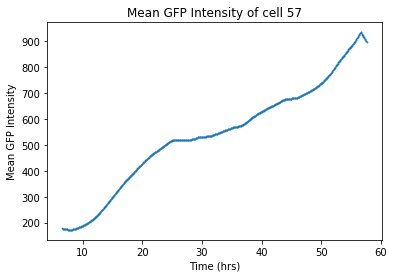

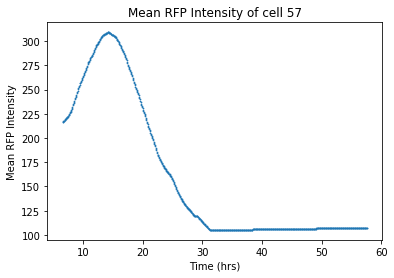

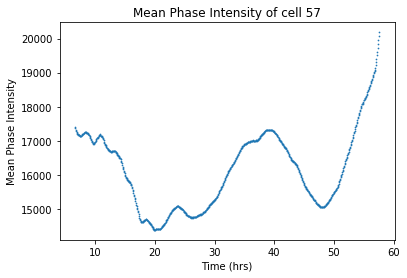

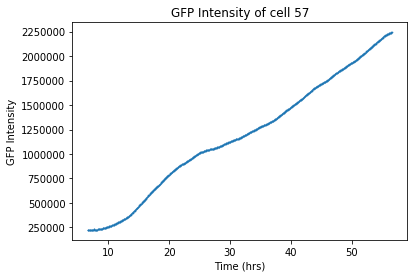

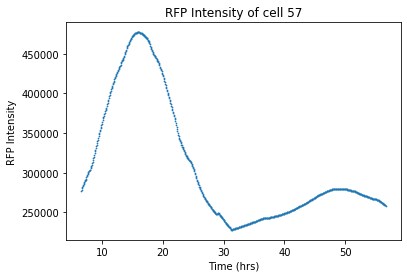

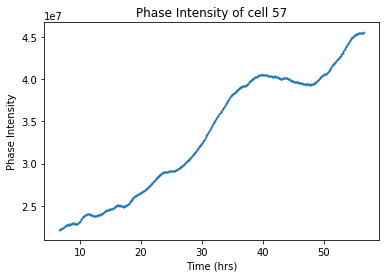

In [12]:
df = pd.read_csv(os.path.join(stat_path, stat_location))
#print(df)
x = df.index
x_time = df.index * 4/60 #for plotting the x axis as hours assuming time period between frames is 4mins
print(df)
y_variables = df.columns[9:12] #this calls just the first four variables 
for y in y_variables:
    intensity = df[y] 
    rolling_mean = df[y].rolling(window=100).mean()
    plt.scatter(x_time,rolling_mean, s= 0.5)
    plt.ylabel(y)
    plt.xlabel('Time (hrs)')
    title = y + ' of cell ' + cell
    plt.title(title)
    plt.show()
    
y_variables = df.columns[2:5] #this calls just the first four variables 
for y in y_variables:
    intensity = df[y] 
    rolling_mean = df[y].rolling(window=100).mean()
    plt.scatter(x_time,rolling_mean, s= 0.5)
    plt.ylabel(y)
    plt.xlabel('Time (hrs)')
    title = y + ' of cell ' + cell
    plt.title(title)
    plt.show()

# Normalised individual data plots

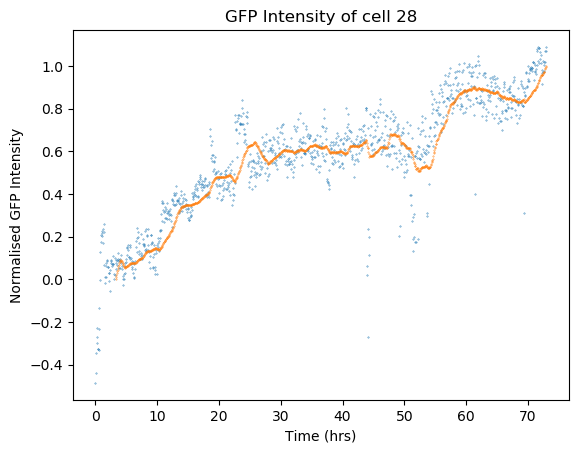

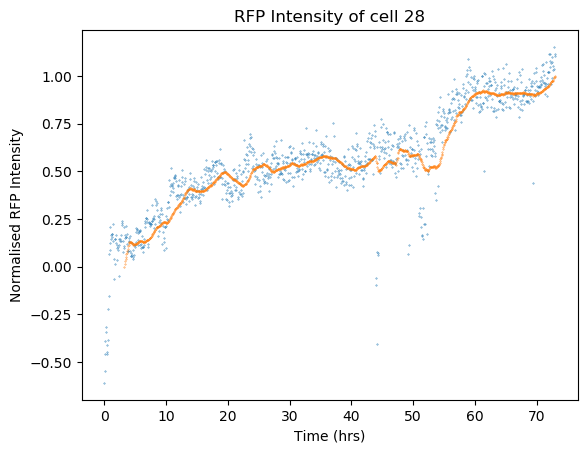

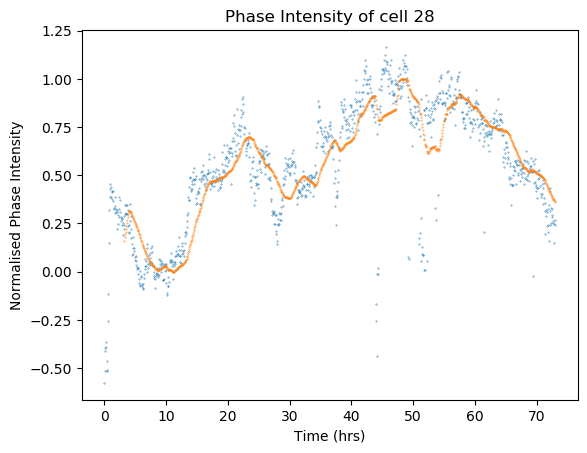

In [409]:
df = pd.read_csv(os.path.join(stat_path, stat_location))
x = df.index
x_time = df.index * 4/60 #for plotting the x axis as hours assuming time period between frames is 4mins

y_variables = df.columns[2:5] #this calls just the first four variables 
for y in y_variables:
    #intensity = df[y] 
    ### Pick method of normalisation ###
    norm_intensity = normalisation(df[y])
    norm_intensity = normalization(df[y])
    norm_intensity = normal(df[y])
    
    rolling_mean = norm_intensity.rolling(window=50).mean()
    plt.scatter(x_time,[norm_intensity], s= 0.1)
    plt.scatter(x_time,rolling_mean, s= 0.1)
    #plt.plot(x_time,[norm_intensity], s= 0.1)
    ylabel = "Normalised " + y
    plt.ylabel(ylabel)
    plt.xlabel('Time (hrs)')
    title = y + ' of cell ' + str(cell)
    plt.title(title)
    plt.show()

# Single-cell overlaid normalised plots of fluorescence - normal gfp/rfp against each or by 1?

Input cell ID
57
     Cell ID  Frame  GFP Intensity  RFP Intensity  Phase Intensity    Area  \
0         57      0       230845.0       237428.0       22690326.0  1119.0   
1         57      1       174617.0       178520.0       16322405.0   825.0   
2         57      2       242701.0       252367.0       20791922.0  1129.0   
3         57      3       222711.0       227521.0       19480499.0  1058.0   
4         57      4       226837.0       243433.0       19849968.0  1068.0   
..       ...    ...            ...            ...              ...     ...   
860       57    860      3127487.0       529491.0      140248472.0  4818.0   
861       57    861      2717427.0       480163.0      130306427.0  4380.0   
862       57    862      2692970.0       498690.0      133947327.0  4474.0   
863       57    863      2527593.0       474393.0      128831243.0  4310.0   
864       57    864      1950585.0       375514.0      107331902.0  3434.0   

       x    y                      mask_fn  Me

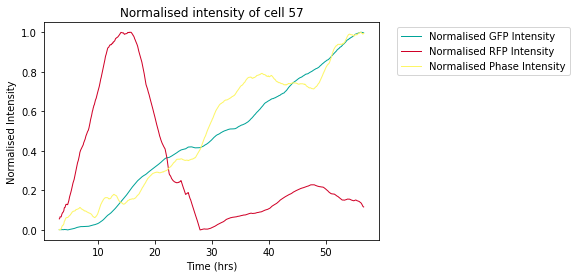

<Figure size 60000x24000 with 0 Axes>

In [9]:
print("Input cell ID")
cell=input()
### Data location ###
stat_path = "/home/nathan/data/SHARC/fucci/fucci1_171201/stats/cellpose_nuclear"
fn = "cell_ID_" + str(cell) + ".csv"
stat_location = os.path.join(stat_path, fn)
df = pd.read_csv(stat_location)

print(df)
### uncomment following line if cell already chosen prior to above ####
#df = pd.read_csv(os.path.join(stat_path, stat_location))
norm_df = pd.DataFrame([])

x = df.index
x_time = df.index * 4/60 #for plotting the x axis as hours assuming time period between frames is 4mins
y_variables = df.columns[0:5] #this calls just the first four variables 

## collect different intensities to normalise and plot ##
for y in y_variables:
        #intensity = df[y] 
        y_name = 'Normalised ' + y
        
        ### pick method of normalisation 
        #norm_intensity = normalisation(df[y]) 
        #norm_intensity = normalization(df[y]) 
        norm_intensity = normal(df[y]) 
        norm_df[y_name] = norm_intensity   

        #plotting intensities on same plot
for column in norm_df.columns[2:5]: #index in df.columns indicate variables to plot
    colour = colour_picker(column)
    rolling_mean = norm_df[column].rolling(window=mean_window).mean()
    plt.plot(x_time, rolling_mean, linewidth=1, color=colour, label = column)
    #plt.plot(x_time, norm_df[column], linewidth=0.5, color=colour, label = column)
#plt.plot(x_time, norm_df["Normalised Area"], linewidth=0.5, color="gray", label = "Normalised Area" )
plt.ylabel("Normalised Intensity")
plt.xlabel('Time (hrs)')
plt.legend()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
title = "Normalised intensity of cell " + str(cell)
#title = norm_df.columns[0]+", "+ norm_df.columns[1]+ ", "+ norm_df.columns[2]+" of cell " + cell
plt.title(title)
plt.figure(figsize=[20,8], dpi=3000)
save_title = title + ".png"
#plt.savefig(os.path.join(stat_path, cell_id, save_title), dpi=1000)
plt.show()

# Single-cell or many-cell overlaid plots of raw fluorescence

Input cell IDs
57


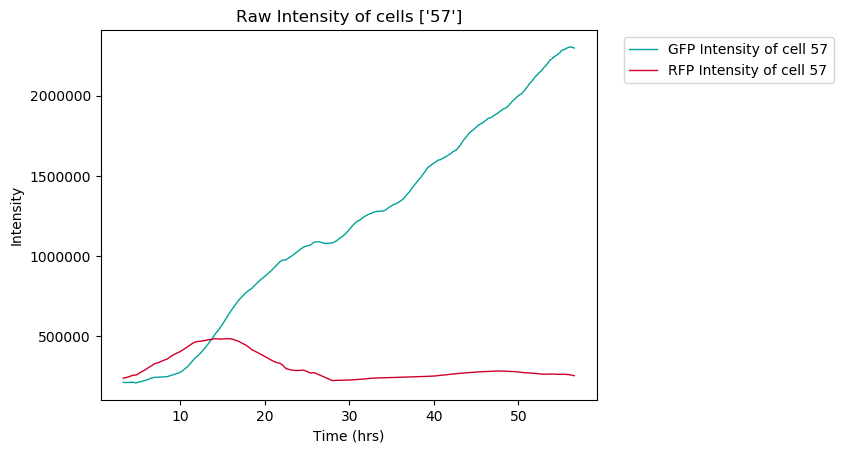

In [524]:
aligned_df = pd.DataFrame([])
#cell_ids = [72, 57, 16, 46, 182, 239, 414, 441, 570, 640, 659, 713, 727, 748]
print("Input cell IDs")
cell_ids = str_convert(input())
#cell_ids = [72,72]
for cell in cell_ids:
    ### Load data
    fn = "cell_ID_" + str(cell) + ".csv"
    stat_location = os.path.join(stat_path, fn)
    df = pd.read_csv(stat_location)
   
    # creating a new column to use in different cells traj. alignment 
    df['Summed Fluoresence Intensity'] = df['GFP Intensity'] + df['RFP Intensity'] 
    #alignment point t0 is the min of total fluorescence ie when the fucci signal goes dark post-mitosis
    t0 = df['Summed Fluoresence Intensity'].idxmin()
    #new aligned_df where t0 is at index 0 
    aligned_df = df.shift(periods = 0)#-t0) #this line of code brings the minimum point to beginning of the df, but discards the preceeding data... fix this by shifting it not to index0 but forwards??  
    x = aligned_df.index
    x_time = aligned_df.index * 4/60 #for plotting the x axis as hours assuming time period between frames is 4mins
    #print(aligned_df)
    #plotting normalised intensities on same plot
    for column in aligned_df.columns[2:4]: #index in df.columns indicate variables to plot, input a variable selection option
        colour = colour_picker(column)
        label = column + " of cell " + str(cell)
        #this conditional statement trims the x variable to be the same length as the y var if it is longer (only a zero index issue really as max length x_var will be 1 more than y_var)
        if len(x_time) > len(aligned_df[column]):
            x_time = x_time[:len(aligned_df[column])]
        #print(len(x_time), len(aligned_df[column]), column, ", cell ", cell, ", t0 is ", t0) #troubleshooter
        #plt.plot(x_time, aligned_df[column][:len(x_time)], linewidth=0.5)#, color=colour)#, label = label)#, color=colour)
        rolling_mean = aligned_df[column][:len(x_time)].rolling(window=mean_window).mean()
        plt.plot(x_time, rolling_mean, linewidth=1, label = label, color=colour)
        #plt.plot(x_time, df["Normalised Area"], linewidth=0.5, color="gray", label = "Normalised Area" )
        
plt.ylabel("Intensity")
plt.xlabel('Time (hrs)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
title = "Raw Intensity of cells " + str(cell_ids)
plt.title(title)
save_title = title + ".png"
#plt.savefig(os.path.join(stat_path, cell_id, save_title), dpi=1000)
plt.show()

# Overlaid many-cell NORMALISED incorrectly? plots, alignment needed _WORK IN PROGRESS_


Input cell IDs
817
2


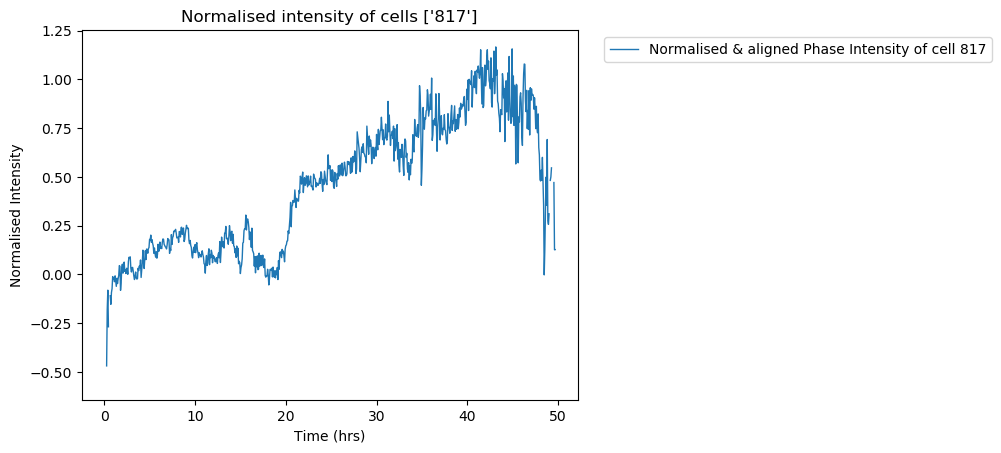

In [483]:
mean_window = 50 # number of periods to define rolling mean by

norm_aligned_df = pd.DataFrame([])
#cell_ids = [72, 57, 16, 46, 182, 239]#,414, 441, 570, 640, 659, 713, 727, 748]

print("Input cell IDs")
cell_ids = str_convert(input())
for cell in cell_ids:
    #cell = 46
    ### Load data
    fn = "cell_ID_" + str(cell) + ".csv"
    stat_location = os.path.join(stat_path, fn)
    df = pd.read_csv(stat_location)
   
    # creating a new column to use in different cells traj. alignment 
    df['Summed Fluoresence Intensity'] = df['GFP Intensity'] + df['RFP Intensity'] 
    #alignment point t0 is the min of total fluorescence ie when the fucci signal goes dark post-mitosis
    t0 = df['Summed Fluoresence Intensity'].idxmin()
    print(t0)
    #new aligned_df where t0 is at index 0
    aligned_df = df.shift(periods = -t0) #this line of code brings the minimum point to beginning of the df, but discards the preceeding data... fix this by shifting it not to index0 but forwards??  
    x = aligned_df.index
    x_time = aligned_df.index * 4/60 #for plotting the x axis as hours assuming time period between frames is 4mins
    
    #normalisation of aligned_df
    y_variables = aligned_df.columns[2:6] #this calls just four variables, gfp, rfp, phase and cell area
    for y in y_variables:
            y_name = 'Normalised & aligned ' + y
            ### pick method of normalisation ### 
            norm_intensity = normal(aligned_df[y]) 
            #norm_intensity = normalization(aligned_df[y]) 
            norm_aligned_df[y_name] = norm_intensity 
    
    #plotting normalised intensities on same plot
    for column in norm_aligned_df.columns[2:3]: #index in df.columns indicate variables to plot, input a variable selection option
        colour = colour_picker(column)
        label = column + " of cell " + str(cell)
        #this conditional statement trims the x variable to be the same length as the y var if it is longer (only a zero index issue really as max length x_var will be 1 more than y_var)
        if len(x_time) > len(norm_aligned_df[column]):
            x_time = x_time[:len(norm_aligned_df[column])]
        #print(len(x_time), len(norm_aligned_df[column]), column, ", cell ", cell, ", t0 is ", t0) #troubleshooter
        plt.plot(x_time, norm_aligned_df[column][:len(x_time)], linewidth=1, label = label)#, color=colour)
        #rolling_mean = norm_aligned_df[column][:len(x_time)].rolling(window=40).mean()
        #plt.plot(x_time, rolling_mean, linewidth=1, label = label)#, color=colour)
        #plt.plot(x_time, norm_df["Normalised Area"], linewidth=0.5, color="gray", label = "Normalised Area" )
        
plt.ylabel("Normalised Intensity")
plt.xlabel('Time (hrs)')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
title = "Normalised intensity of cells " + str(cell_ids)
plt.title(title)
save_title = title + ".png"
#plt.savefig(os.path.join(stat_path, cell_id, save_title), dpi=1000)
plt.show()



# Meta-analysis of tracks

Iteratively load all track dataframes in root_path

In [437]:
stat_path = "/home/nathan/data/SHARC/fucci/fucci1_171201/stats/cellpose_nuclear"
cell_track_fns = natsorted([m for m in os.listdir(stat_path) if m.endswith('.csv')])
df_list = []
for cell_track_fn in cell_track_fns:
    stat_location = os.path.join(stat_path, cell_track_fn)
    df_name = cell_track_fn.replace('.csv','_df')
    df_list.append(df_name)
    exec('{} = pd.read_csv(stat_location)'.format(df_name))    

print(cell_track_fns)

['cell_ID_2.csv', 'cell_ID_3.csv', 'cell_ID_4.csv', 'cell_ID_5.csv', 'cell_ID_6.csv', 'cell_ID_7.csv', 'cell_ID_10.csv', 'cell_ID_12.csv', 'cell_ID_13.csv', 'cell_ID_16.csv', 'cell_ID_17.csv', 'cell_ID_18.csv', 'cell_ID_19.csv', 'cell_ID_20.csv', 'cell_ID_21.csv', 'cell_ID_22.csv', 'cell_ID_26.csv', 'cell_ID_28.csv', 'cell_ID_34.csv', 'cell_ID_37.csv', 'cell_ID_39.csv', 'cell_ID_43.csv', 'cell_ID_45.csv', 'cell_ID_46.csv', 'cell_ID_48.csv', 'cell_ID_49.csv', 'cell_ID_50.csv', 'cell_ID_51.csv', 'cell_ID_52.csv', 'cell_ID_54.csv', 'cell_ID_56.csv', 'cell_ID_57.csv', 'cell_ID_58.csv', 'cell_ID_61.csv', 'cell_ID_62.csv', 'cell_ID_63.csv', 'cell_ID_64.csv', 'cell_ID_65.csv', 'cell_ID_66.csv', 'cell_ID_68.csv', 'cell_ID_69.csv', 'cell_ID_70.csv', 'cell_ID_72.csv', 'cell_ID_73.csv', 'cell_ID_74.csv', 'cell_ID_77.csv', 'cell_ID_78.csv', 'cell_ID_80.csv', 'cell_ID_82.csv', 'cell_ID_84.csv', 'cell_ID_85.csv', 'cell_ID_86.csv', 'cell_ID_87.csv', 'cell_ID_91.csv', 'cell_ID_92.csv', 'cell_ID_94.csv

List track lengths and plot histogram

In [438]:
for cell_track_fn in cell_track_fns:
    stat_location = os.path.join(stat_path, cell_track_fn)  
    if (len(pd.read_csv(stat_location))) > 700:
            print(cell_track_fn.replace('.csv',' exists for'), len(pd.read_csv(stat_location)), "frames")

cell_ID_5 exists for 756 frames
cell_ID_16 exists for 803 frames
cell_ID_20 exists for 719 frames
cell_ID_28 exists for 1095 frames
cell_ID_43 exists for 811 frames
cell_ID_46 exists for 1092 frames
cell_ID_57 exists for 865 frames
cell_ID_72 exists for 1091 frames
cell_ID_164 exists for 762 frames
cell_ID_182 exists for 1062 frames
cell_ID_239 exists for 1030 frames
cell_ID_260 exists for 714 frames
cell_ID_330 exists for 711 frames
cell_ID_414 exists for 857 frames
cell_ID_441 exists for 938 frames
cell_ID_503 exists for 756 frames
cell_ID_570 exists for 879 frames
cell_ID_640 exists for 846 frames
cell_ID_659 exists for 838 frames
cell_ID_713 exists for 815 frames
cell_ID_727 exists for 810 frames
cell_ID_748 exists for 804 frames
cell_ID_817 exists for 748 frames
cell_ID_1100 exists for 811 frames
cell_ID_1352 exists for 1872 frames
cell_ID_1646 exists for 1872 frames


In [ ]:
track_lengths = []
for cell_track_fn in cell_track_fns:
    stat_location = os.path.join(stat_path, cell_track_fn) 
    track_lengths.append(len(pd.read_csv(stat_location)))


tracks_df = pd.Series(track_lengths)
#print(max(tracks_df))

tracks_df.plot.hist(grid=True, bins=25, rwidth=0.9,
                   color='#607c8e')
title = 'Distribution of track lengths cellpose'
plt.title(title)
plt.xlabel('Track length')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# FUCCI-time x-variable creation

Input cell IDs
7
t = S-phase looks to be 174 frames
t = Mitosis looks to be 522 frames


/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37:

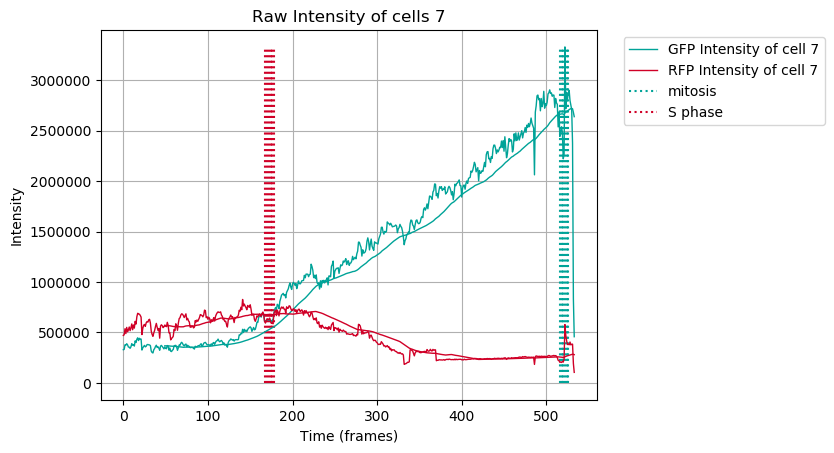

In [517]:
mean_window = 50 # number of periods to define rolling mean by


#print(df)
print("Input cell IDs")
cell =input() 

fn = "cell_ID_" + str(cell) + ".csv"
stat_location = os.path.join(stat_path, fn)
df = pd.read_csv(stat_location)

# creating a new column to use in different cells traj. alignment 
df['Sum FI'] = df['GFP Intensity'] + df['RFP Intensity'] #summed fluoresence intensity
df['delta FI'] = df['GFP Intensity'] - df['RFP Intensity'] #difference between fluoresence intensity

### defining the onset of S phase (tS) as when the difference between green and red channels is minimum ###
tS = (abs(df['delta FI']).idxmin())
print("t = S-phase looks to be", tS, "frames")

### defining the approx onset of M phase as when the difference between green and red channels is max ###
tM = df['delta FI'].idxmax()
print("t = Mitosis looks to be", tM, "frames")

### OR defining the approx onset of M phase as when the green is max using rolling mean ### !!!!!!!!!!!!!!!!!!!
#tM = df['GFP Intensity'].rolling(window=40).idxmax()
#print("t = Mitosis looks to be", tM, "frames")

### storing marker points in the fucci time column... plot this column somehow?
df["FUCCI phase"] = "Uncertain" # first populate column with uncertainty
for idx in df.index:
    if df['delta FI'][idx] < 0:
        df['FUCCI phase'][idx] = "G1"
    if df['delta FI'][idx] > 0:
        df['FUCCI phase'][idx] = "S/G2/M"
    if df['Area'][idx] < 1000: # this condition deems phase estimation uncertain if mask is small
        df['FUCCI phase'][idx] = "Uncertain"
df["FUCCI phase"][tS-1:tS+2] = "G1 to S phase transition"
df["FUCCI phase"][tM-1:tM+2] = "Mitosis to G1 phase transition"

### creation of FUCCI time column for alignment, t0 = 0, tS = 1, tM = 2
df["FUCCI time"] = 0
df["FUCCI time"][tS:tS+1] = 1
df["FUCCI time"][tM:tM+1] = 2

x = df["Frame"]
x_time = df["Frame"] * 4/60 #for plotting the x axis as hours assuming time period between frames is 4mins

columns = ["GFP Intensity", "RFP Intensity"]#, "Sum FI", "delta FI"]
#plotting normalised intensities on same plot
for column in columns: #index in df.columns indicate variables to plot, input a variable selection option
    colour = colour_picker(column)
    label = column + " of cell " + str(cell)
    #this conditional statement trims the x variable to be the same length as the y var if it is longer (only a zero index issue really as max length x_var will be 1 more than y_var)
    #print(len(x_time), len(aligned_df[column]), column, ", cell ", cell, ", t0 is ", t0) #troubleshooter
    plt.plot(x, df[column], linewidth=1, color=colour)#, label = label)#, color=colour)
    rolling_mean = df[column].rolling(window=mean_window).mean()
    #plt.plot(x_time, rolling_mean, linewidth=1, label = label, color=colour)
    plt.plot(x, rolling_mean,  label = label, color=colour, linewidth=1)
    #plt.plot(x_time, df["Normalised Area"], linewidth=0.5, color="gray", label = "Normalised Area" )
plt.grid(which = "both")        
plt.ylabel("Intensity")
plt.xlabel('Time (frames)')
title = "Raw Intensity of cells " + str(cell)

plt.title(title)
save_title = title + ".png"
### phase checkpoints
x_tM = tM+mean_window/2 
x_tS = tS+mean_window/2
x_error_range = 6
x_tM = [int("{}".format(tM+i)) for i in range(-x_error_range,x_error_range)[::2]] ## this range should represent the error in estimation of the mitotic phase!!!!!!!!!!!!!!!!
x_tS = [int("{}".format(tS+i)) for i in range(-x_error_range,x_error_range)[::2]] ## this range should represent the error in estimation of the mitotic phase!!!!!!!!!!!!!!!!
plt.vlines(x_tM, 0, df["GFP Intensity"].max(), label = "mitosis", colors = '#00A398', linestyle = "dotted")#, ymin, ymax, colors='k', linestyles='solid', label='', *, data=None, **kwargs)
plt.vlines(x_tS, 0, df["GFP Intensity"].max(), label = "S phase", colors = "#D00027", linestyle = "dotted")#, ymin, ymax, colors='k', linestyles='solid', label='', *, data=None, **kwargs)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
#plt.style.use('default')
#plt.savefig(os.path.join(stat_path, cell_id, save_title), dpi=1000)

plt.show()

## this is for testing the FUCCI phase column
#df.to_csv("/home/nathan/data/SHARC/fucci/fucci1_171201/stats/test.csv", index = False)

In [ ]:

### ROW BY ROW FUCCI PHASE analysis... should do rolling mean?
#if df['delta FI']..rolling(window=25) is negative then df['FUCCI phase'] = "G1"
print(df)
df["FUCCI phase"] = "Uncertain" # first populate column with uncertainty
for idx in df.index:
    if df['delta FI'][idx] < 0:
        df['FUCCI phase'][idx] = "G1"
    if df['delta FI'][idx] > 0:
        df['FUCCI phase'][idx] = "S/G2/M"
    if df['Area'][idx] < 1000: # this condition deems phase estimation uncertain if mask is small
        df['FUCCI phase'][idx] = "Uncertain"
df["FUCCI phase"][tS-1:tS+2] = "G1 to S phase transition"
df["FUCCI phase"][tM-1:tM+2] = "Mitosis to G1 phase transition"
print(df)

df.to_csv("/home/nathan/data/SHARC/fucci/fucci1_171201/stats/test.csv", index = False)

# track concatenator
code probably needs a bit more work - execute with caution!

In [ ]:
df1 = []
df2 = []
df3 = []

print("Input the cell IDs of the split tracks - WARNING: will overwrite both original .csv files with merged .csv")
tracks_2_concat = str_convert(input())

cell_track_fn1 = "cell_ID_" + str(tracks_2_concat[0]) + ".csv"
stat_location1 = os.path.join(stat_path, cell_track_fn1)
print(stat_location1)
df1 = pd.read_csv(stat_location1)
cell_track_fn2 = "cell_ID_" + str(tracks_2_concat[1]) + ".csv"
stat_location2 = os.path.join(stat_path, cell_track_fn2)
print(stat_location2)

df2 = pd.read_csv(stat_location2)
df3 = df1.append(df2, ignore_index=True)
df3.to_csv(stat_location1, index=False) # this overwrites both files with new ones
df3.to_csv(stat_location2, index=False)
print(df1, df2, df3)


# glimpse creator

In [528]:


import numpy as np
import tifffile as tiff
import glob
import matplotlib.pyplot as plt
import os, re
from tensorflow.python.keras.models import Model, load_model
import json
import zipfile
import scipy
from scipy.spatial import KDTree
from skimage.transform import resize
from multiprocessing import Pool
from btrack.dataio import HDF5FileHandler


# In[3]:


def Glimpse_from_Track(track,GFP_image_stack,RFP_image_stack):
    # Movie Dimensions
    movie_width = GFP_image_stack.shape[1] # GFP_image_stack.shape = (t,x,y)
    movie_height = GFP_image_stack.shape[2]
    view_dims = [64,128,256]
    # Tracks
    track_t = np.array(track.t,dtype=int)
    track_x = np.array(track.x,dtype=int)
    track_y = np.array(track.y,dtype=int)
    low_t,high_t = track_t[0],track_t[-1]+1
    # Empty Glimpse Array to Fill
    glimpse = np.zeros((len(track_t),3,2,64,64)) # (timesteps,views,channels,width,height)
    # Zero-Pad GFP and RFP full-view images
    GFP_image_stack_padded = np.pad(GFP_image_stack,((0,0),(256,256),(256,256)),'constant',constant_values=((0.,0.),(0.,0.),(0.,0.)))
    RFP_image_stack_padded = np.pad(RFP_image_stack,((0,0),(256,256),(256,256)),'constant',constant_values=((0.,0.),(0.,0.),(0.,0.)))
    # Form GFP and RFP Glimpses
    for frame in range(len(track_t)):
        x,y,t = track_x[frame]+256,track_y[frame]+256,track_t[frame] # +256 to account for zero-padding
        glimpse[frame,0,0,:,:] = GFP_image_stack_padded[t,x-32:x+32,y-32:y+32]
        glimpse[frame,1,0,:,:] = resize(np.array(GFP_image_stack_padded[t,x-64:x+64,y-64:y+64],dtype=np.float32),(64,64)) 
        glimpse[frame,2,0,:,:] = resize(np.array(GFP_image_stack_padded[t,x-128:x+128,y-128:y+128],dtype=np.float32),(64,64)) 
        glimpse[frame,0,1,:,:] = RFP_image_stack_padded[t,x-32:x+32,y-32:y+32]
        glimpse[frame,1,1,:,:] = resize(np.array(RFP_image_stack_padded[t,x-64:x+64,y-64:y+64],dtype=np.float32),(64,64)) 
        glimpse[frame,2,1,:,:] = resize(np.array(RFP_image_stack_padded[t,x-128:x+128,y-128:y+128],dtype=np.float32),(64,64))
    glimpse = np.array(glimpse,dtype=np.uint8) # integer format
    return glimpse


# In[4]:


def Create_Glimpses(GV,pos): # (e.g. 'GV0795',Pos3') ## or could be 
    #pos_folder = os.path.join('/media/chris/Data/Giulia_Movies_for_Labelling/',GV,pos) 
    pos_folder = "/home/nathan/data/SHARC/fucci/fucci1_171201/"
#     fn = "cell_ID_" + str(cell) + ".csv"
#     stat_location = os.path.join(root_path, fn)
#     df = pd.read_csv(stat_location)
    tracks_file = pos_folder+'/HDF/'+ version + '.h5' ### should it be hdf5?
    glimpse_folder = os.path.join(pos_folder,'glimpses')
    Path(glimpse_folder).mkdir(parents=True, exist_ok=True) ## create glimpse folder
    # Image Stacks    
    GFP_address = glob.glob(str(pos_folder)+'/'+str(pos)+'_GFP.tif')[0]
    RFP_address = glob.glob(str(pos_folder)+'/'+str(pos)+'_RFP.tif')[0]
    GFP_image_stack = tiff.imread(GFP_address) # (t,x,y)
    RFP_image_stack = tiff.imread(RFP_address) # (t,x,y)
    # Tracks
    for cell_type in ['GFP','RFP']:
        if cell_type == 'GFP':
            main_channel = 0
        elif cell_type == 'RFP':
            main_channel = 1
        try:
            with HDF5FileHandler(tracks_file) as h:
                tracks = h.tracks[main_channel]
        except OSError:
            continue
        for track in tracks:
            ID = track.ID
            glimpse = Glimpse_from_Track(track,GFP_image_stack,RFP_image_stack)
            glimpse_name = str(GV)+'_'+'_'+str(pos)+'_'+str(ID)+'_'+str(cell_type)
            with tiff.TiffWriter(str(glimpse_folder)+'/'+str(glimpse_name)+'.tif',imagej=True) as tif:
                tif.save(glimpse)


# In[7]:


Create_Glimpses('GV0795','Pos4')

IndexError: list index out of range

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, re
from scipy import ndimage
from skimage.io import imshow #used to be from skimage import io
from sklearn import preprocessing
from matplotlib import animation
from natsort import natsorted
from pathlib import Path
from skimage.external import tifffile
from btrack.dataio import HDF5FileHandler


import glob
from tensorflow.python.keras.models import Model, load_model
import json
import zipfile
import scipy
from scipy.spatial import KDTree
from skimage.transform import resize
from multiprocessing import Pool


cell = 7
i=0
mask_version = 'cellpose_nuclear'
root_path = "/home/nathan/data/SHARC/fucci/fucci1_171201/"
tracks_file = root_path+'/HDF/'+ mask_version + '.h5' ### should it be hdf5?
glimpse_folder = os.path.join(root_path,'glimpses')
Path(glimpse_folder).mkdir(parents=True, exist_ok=True) ## create glimpse folder
# Image Stacks    
gfp_file_list = natsorted([file for file in os.listdir(os.path.join(root_path, 'gfp')) if file.endswith('.tif')])
GFP_image_stack = tifffile.imread(os.path.join(root_path, 'gfp', gfp_file_list[i]))
rfp_file_list = natsorted([file for file in os.listdir(os.path.join(root_path, 'rfp')) if file.endswith('.tif')])
RFP_image_stack = tifffile.imread(os.path.join(root_path, 'rfp', rfp_file_list[i]))
#phase_file_list = natsorted([file for file in os.listdir(os.path.join(root_path, 'phase')) if file.endswith('.tif')])
#phase_image_stack = tifffile.imread(os.path.join(root_path, 'phase', phase_file_list[i]))

with tifffile.TiffWriter(os.path.join(root_path, 'gfp.tiff')) as stack: #output path
    path = os.path.join(root_path, 'gfp') #input path
    file_list = natsorted([file for file in os.listdir(path) if file.endswith('.tif')])
    for filename in file_list:
        stack.save(tifffile.imread(os.path.join(path, filename)))
print(file_list, "SAVED AS TIFF STACK")
                         
with tifffile.TiffWriter(os.path.join(root_path, 'rfp.tiff')) as stack: #output path
    path = os.path.join(root_path, 'rfp') #input path
    file_list = natsorted([file for file in os.listdir(path) if file.endswith('.tif')])
    for filename in file_list:
        stack.save(tifffile.imread(os.path.join(path, filename)))
print(file_list, "SAVED AS TIFF STACK")

GFP_image_stack = tifffile.imread(os.path.join(root_path, 'gfp.tiff'))
RFP_image_stack = tifffile.imread(os.path.join(root_path, 'rfp.tiff'))

with HDF5FileHandler(tracks_file) as h:
    tracks = h.tracks[0]
track_IDs = ([track.ID for track in tracks])
track_index = track_IDs.index(cell)
track = tracks[track_index]

movie_width = GFP_image_stack.shape[1] # GFP_image_stack.shape = (t,x,y)
movie_height = GFP_image_stack.shape[0]
view_dims = [64,128,256]
# Tracks
track_t = np.array(track.t,dtype=int)
track_x = np.array(track.x,dtype=int)
track_y = np.array(track.y,dtype=int)
low_t,high_t = track_t[0],track_t[-1]+1
# Empty Glimpse Array to Fill
glimpse = np.zeros((len(track_t),3,2,64,64)) # (timesteps,views,channels,width,height)
# Zero-Pad GFP and RFP full-view images
GFP_image_stack_padded = np.pad(GFP_image_stack,((0,0),(256,256),(256,256)),'constant',constant_values=((0.,0.),(0.,0.),(0.,0.)))
RFP_image_stack_padded = np.pad(RFP_image_stack,((0,0),(256,256),(256,256)),'constant',constant_values=((0.,0.),(0.,0.),(0.,0.)))

#GFP_image_stack_padded = np.pad(GFP_image_stack,((256,256),(256,256)),'constant',constant_values=((0.,0.),(0.,0.)))
#RFP_image_stack_padded = np.pad(RFP_image_stack,((256,256),(256,256)),'constant',constant_values=((0.,0.),(0.,0.)))
# Form GFP and RFP Glimpses
for frame in range(len(track_t)):
    x,y,t = track_x[frame]+256,track_y[frame]+256,track_t[frame] # +256 to account for zero-padding
    print(x,y,t)
    glimpse[frame,0,0,:,:] = GFP_image_stack_padded[t,x-32:x+32,y-32:y+32]
    glimpse[frame,1,0,:,:] = resize(np.array(GFP_image_stack_padded[t,x-64:x+64,y-64:y+64],dtype=np.float32),(64,64)) 
    glimpse[frame,2,0,:,:] = resize(np.array(GFP_image_stack_padded[t,x-128:x+128,y-128:y+128],dtype=np.float32),(64,64)) 
    #glimpse[frame,0,1,:,:] = RFP_image_stack_padded[t,x-32:x+32,y-32:y+32]
    #glimpse[frame,1,1,:,:] = resize(np.array(RFP_image_stack_padded[t,x-64:x+64,y-64:y+64],dtype=np.float32),(64,64)) 
    #glimpse[frame,2,1,:,:] = resize(np.array(RFP_image_stack_padded[t,x-128:x+128,y-128:y+128],dtype=np.float32),(64,64))
glimpse = np.array(glimpse,dtype=np.uint8) # integer format


# for track in tracks:
#     ID = track.ID
#     glimpse = Glimpse_from_Track(track,GFP_image_stack,RFP_image_stack)
#     glimpse_name = str(GV)+'_'+'_'+str(pos)+'_'+str(ID)+'_'+str(cell_type)
#     with tiff.TiffWriter(str(glimpse_folder)+'/'+str(glimpse_name)+'.tif',imagej=True) as tif:
#         tif.save(glimpse)

['0000_gfp.tif', '0001_gfp.tif', '0002_gfp.tif', '0003_gfp.tif', '0004_gfp.tif', '0005_gfp.tif', '0006_gfp.tif', '0007_gfp.tif', '0008_gfp.tif', '0009_gfp.tif', '0010_gfp.tif', '0011_gfp.tif', '0012_gfp.tif', '0013_gfp.tif', '0014_gfp.tif', '0015_gfp.tif', '0016_gfp.tif', '0017_gfp.tif', '0018_gfp.tif', '0019_gfp.tif', '0020_gfp.tif', '0021_gfp.tif', '0022_gfp.tif', '0023_gfp.tif', '0024_gfp.tif', '0025_gfp.tif', '0026_gfp.tif', '0027_gfp.tif', '0028_gfp.tif', '0029_gfp.tif', '0030_gfp.tif', '0031_gfp.tif', '0032_gfp.tif', '0033_gfp.tif', '0034_gfp.tif', '0035_gfp.tif', '0036_gfp.tif', '0037_gfp.tif', '0038_gfp.tif', '0039_gfp.tif', '0040_gfp.tif', '0041_gfp.tif', '0042_gfp.tif', '0043_gfp.tif', '0044_gfp.tif', '0045_gfp.tif', '0046_gfp.tif', '0047_gfp.tif', '0048_gfp.tif', '0049_gfp.tif', '0050_gfp.tif', '0051_gfp.tif', '0052_gfp.tif', '0053_gfp.tif', '0054_gfp.tif', '0055_gfp.tif', '0056_gfp.tif', '0057_gfp.tif', '0058_gfp.tif', '0059_gfp.tif', '0060_gfp.tif', '0061_gfp.tif', '0062_g

['0000_rfp.tif', '0001_rfp.tif', '0002_rfp.tif', '0003_rfp.tif', '0004_rfp.tif', '0005_rfp.tif', '0006_rfp.tif', '0007_rfp.tif', '0008_rfp.tif', '0009_rfp.tif', '0010_rfp.tif', '0011_rfp.tif', '0012_rfp.tif', '0013_rfp.tif', '0014_rfp.tif', '0015_rfp.tif', '0016_rfp.tif', '0017_rfp.tif', '0018_rfp.tif', '0019_rfp.tif', '0020_rfp.tif', '0021_rfp.tif', '0022_rfp.tif', '0023_rfp.tif', '0024_rfp.tif', '0025_rfp.tif', '0026_rfp.tif', '0027_rfp.tif', '0028_rfp.tif', '0029_rfp.tif', '0030_rfp.tif', '0031_rfp.tif', '0032_rfp.tif', '0033_rfp.tif', '0034_rfp.tif', '0035_rfp.tif', '0036_rfp.tif', '0037_rfp.tif', '0038_rfp.tif', '0039_rfp.tif', '0040_rfp.tif', '0041_rfp.tif', '0042_rfp.tif', '0043_rfp.tif', '0044_rfp.tif', '0045_rfp.tif', '0046_rfp.tif', '0047_rfp.tif', '0048_rfp.tif', '0049_rfp.tif', '0050_rfp.tif', '0051_rfp.tif', '0052_rfp.tif', '0053_rfp.tif', '0054_rfp.tif', '0055_rfp.tif', '0056_rfp.tif', '0057_rfp.tif', '0058_rfp.tif', '0059_rfp.tif', '0060_rfp.tif', '0061_rfp.tif', '0062_r

[INFO][2020/08/10 11:59:17 AM] Opening HDF file: /home/nathan/data/SHARC/fucci/fucci1_171201//HDF/cellpose_nuclear.h5
[INFO][2020/08/10 11:59:17 AM] Loading tracks: obj_type_1...
[INFO][2020/08/10 11:59:17 AM] Loading obj_type_1 (160396, 5) (160396 filtered: None)...
[INFO][2020/08/10 11:59:19 AM] Closing HDF file: /home/nathan/data/SHARC/fucci/fucci1_171201//HDF/cellpose_nuclear.h5


In [12]:
print(x,y,t)

1006 400 0
